In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def sine_wave(num_samples , t ):
    x = np.zeros(shape = [num_samples , t])
    y = np.zeros(shape = [num_samples , t])
    for i in range(num_samples) : 
        seq = np.sin(np.linspace(2*i*np.pi  , 2*(i+1)*np.pi , t+1) )
        x[i][:] = seq[:-1]
        y[i][:] = seq[1:]
    return x , y    

In [6]:
class SineWaveDataset(Dataset):
    def __init__(self, num_samples, t):
        self.x, self.y = sine_wave(num_samples, t)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
num_samples = 1000
t = 50
batch_size = 32

dataset = SineWaveDataset(num_samples, t)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [36]:
class LSTM(nn.Module):
    def __init__(self,input_size , hidden_size ,output_size):
        super().__init__() 
        self.input_size = input_size;
        self.hidden_size = hidden_size;
        self.output_size = output_size;
        self.W_f = nn.Parameter(torch.Tensor(input_size+hidden_size,hidden_size));
        self.W_u= nn.Parameter(torch.Tensor(input_size+hidden_size,hidden_size));
        self.W_c= nn.Parameter(torch.Tensor(input_size+hidden_size,hidden_size));
        self.W_o =nn.Parameter(torch.Tensor(hidden_size+input_size,output_size));
        self.b_f  = nn.Parameter(torch.zeros(hidden_size))
        self.b_u  = nn.Parameter(torch.zeros(output_size))
        self.b_o  = nn.Parameter(torch.zeros(output_size))
        self.b_c  = nn.Parameter(torch.zeros(output_size))
        self.fc = nn.Linear(hidden_size, output_size)
        nn.init.xavier_uniform_(self.W_f)
        nn.init.xavier_uniform_(self.W_u)
        nn.init.xavier_uniform_(self.W_o)
        nn.init.xavier_uniform_(self.W_c)


    def forward(self,X,hidden_state = None ,cell_state = None):
        batch_size,len_seq,input_size = X.size()
        outputs = torch.zeros(batch_size, len_seq, self.output_size)
        if(hidden_state == None) :
            hidden_state = torch.zeros(batch_size,self.hidden_size)
        if(cell_state == None) :
            cell_state = hidden_state
        for t in range(len_seq):
            x_t = X[:,t,:]
            combined = torch.cat((x_t,hidden_state),dim=1)
            forget = torch.matmul(combined,self.W_f) + self.b_f
            forget = torch.sigmoid(forget)
            update = torch.matmul(combined,self.W_u)+self.b_u
            update = torch.sigmoid(update)
            output_gate = torch.matmul(combined,self.W_o) + self.b_o
            output_gate = torch.sigmoid(output_gate)
            candidate = torch.tanh(torch.matmul(combined,self.W_c)+self.b_c)
            cell_state = forget*cell_state + update*candidate
            hidden_state = output_gate*torch.tanh(cell_state)
            y_t = self.fc(hidden_state)
            outputs[:, t, :] = y_t
        return outputs    
                   
   

In [62]:
batch_size = 32
hidden_size = 32
model = LSTM(1,32,1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [63]:
num_epochs = 10
for epoch in range(num_epochs) :
    model.train()
    running_loss = 0.0
    for i , (x_batch,y_batch) in enumerate(tqdm(dataloader,desc = f"Epoch {epoch+1}/{num_epochs}")):
        x_batch = x_batch.unsqueeze(-1)
        hidden_state = torch.zeros(x_batch.size()[0],hidden_size)
        cell_state = hidden_state
        y_pred = model(x_batch,hidden_state,cell_state)
        y_pred = y_pred.squeeze(-1)
        loss = loss_fn(y_pred,y_batch)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1)%15== 0 :
            print(f"Step[{i+1}/{len(dataloader)}].:  Loss: {loss.item():.4f}")
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {running_loss / len(dataloader):.4f}")        
        
        

Epoch 1/10:  59%|█████████████████████████████████████████▌                            | 19/32 [00:00<00:00, 32.79it/s]

Step[15/32].:  Loss: 0.4852


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.25it/s]


Step[30/32].:  Loss: 0.4741
Epoch 1/10 - Average Loss: 0.4841


Epoch 2/10:  69%|████████████████████████████████████████████████▏                     | 22/32 [00:00<00:00, 36.98it/s]

Step[15/32].:  Loss: 0.4615


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.59it/s]


Step[30/32].:  Loss: 0.4502
Epoch 2/10 - Average Loss: 0.4603


Epoch 3/10:  69%|████████████████████████████████████████████████▏                     | 22/32 [00:00<00:00, 40.65it/s]

Step[15/32].:  Loss: 0.4371


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.46it/s]


Step[30/32].:  Loss: 0.4253
Epoch 3/10 - Average Loss: 0.4359


Epoch 4/10:  62%|███████████████████████████████████████████▊                          | 20/32 [00:00<00:00, 44.17it/s]

Step[15/32].:  Loss: 0.4114


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 43.32it/s]


Step[30/32].:  Loss: 0.3986
Epoch 4/10 - Average Loss: 0.4100


Epoch 5/10:  62%|███████████████████████████████████████████▊                          | 20/32 [00:00<00:00, 44.27it/s]

Step[15/32].:  Loss: 0.3834


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.47it/s]


Step[30/32].:  Loss: 0.3693
Epoch 5/10 - Average Loss: 0.3819


Epoch 6/10:  62%|███████████████████████████████████████████▊                          | 20/32 [00:00<00:00, 43.85it/s]

Step[15/32].:  Loss: 0.3523


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.46it/s]


Step[30/32].:  Loss: 0.3365
Epoch 6/10 - Average Loss: 0.3506


Epoch 7/10:  62%|███████████████████████████████████████████▊                          | 20/32 [00:00<00:00, 42.02it/s]

Step[15/32].:  Loss: 0.3176


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.34it/s]


Step[30/32].:  Loss: 0.3004
Epoch 7/10 - Average Loss: 0.3159


Epoch 8/10:  62%|███████████████████████████████████████████▊                          | 20/32 [00:00<00:00, 42.63it/s]

Step[15/32].:  Loss: 0.2811


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.91it/s]


Step[30/32].:  Loss: 0.2652
Epoch 8/10 - Average Loss: 0.2797


Epoch 9/10:  62%|███████████████████████████████████████████▊                          | 20/32 [00:00<00:00, 42.34it/s]

Step[15/32].:  Loss: 0.2492


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.37it/s]


Step[30/32].:  Loss: 0.2361
Epoch 9/10 - Average Loss: 0.2480


Epoch 10/10:  62%|███████████████████████████████████████████▏                         | 20/32 [00:00<00:00, 41.63it/s]

Step[15/32].:  Loss: 0.2217


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.44it/s]

Step[30/32].:  Loss: 0.2090
Epoch 10/10 - Average Loss: 0.2204


In [64]:

x,y = dataset[0]
x,y
model.eval()
with torch.no_grad():
    x = x.unsqueeze(0).unsqueeze(-1)  
    print(x.shape)  
    # hidden_state = torch.zeros(x.size(0), 32)  
    y_pred = model(x)
    y_pred = y_pred.squeeze(-1)
print("Predicted output:", y_pred)

torch.Size([1, 50, 1])
Predicted output: tensor([[-0.1273, -0.1204, -0.1052, -0.0798, -0.0431,  0.0048,  0.0630,  0.1296,
          0.2020,  0.2771,  0.3512,  0.4206,  0.4818,  0.5316,  0.5679,  0.5897,
          0.5967,  0.5898,  0.5698,  0.5376,  0.4942,  0.4402,  0.3766,  0.3046,
          0.2263,  0.1441,  0.0614, -0.0180, -0.0909, -0.1545, -0.2077, -0.2505,
         -0.2838, -0.3091, -0.3280, -0.3419, -0.3522, -0.3597, -0.3652, -0.3691,
         -0.3717, -0.3730, -0.3730, -0.3714, -0.3678, -0.3616, -0.3522, -0.3389,
         -0.3208, -0.2971]])


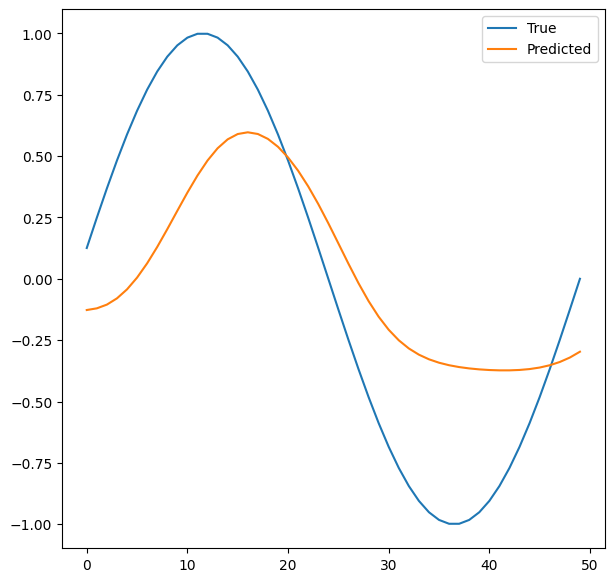

In [65]:
plt.figure(figsize=(7,7))
plt.plot(y, label='True')
plt.plot(y_pred[0], label='Predicted')
plt.legend()
plt.show()
